In [1]:
'''Import necessary libraries'''

import numpy as np
import math
rng = np.random.default_rng()  
import matplotlib.pylab as plt
import random

In [3]:
'''generate the array of temperatures of interest
logarithmic, so more points at low temperatures'''
n = np.linspace(0,100,101)
Tmax = 5
Tmin = 0.1
b = (Tmax/Tmin)**(1/100)
Tn = Tmax/(b**n) 
print(Tn)

[5.         4.80817542 4.62371018 4.44632193 4.27573917 4.1117008
 3.95395574 3.80226257 3.65638909 3.51611203 3.38121669 3.2514966
 3.12675321 3.00679558 2.89144013 2.78051027 2.67383623 2.57125473
 2.47260876 2.37774733 2.28652526 2.19880291 2.11444602 2.03332548
 1.95531712 1.88030155 1.80816394 1.73879388 1.6720852  1.60793579
 1.54624747 1.48692582 1.42988004 1.37502281 1.32227018 1.27154139
 1.22275882 1.17584778 1.13073648 1.08735587 1.04563955 1.00552368
 0.96694685 0.92985002 0.8941764  0.8598714  0.8268825  0.79515923
 0.76465301 0.73531716 0.70710678 0.67997869 0.65389136 0.62880488
 0.60468083 0.5814823  0.55917378 0.53772113 0.5170915  0.49725333
 0.47817625 0.45983106 0.44218968 0.42522511 0.40891138 0.39322353
 0.37813755 0.36363033 0.34967968 0.33626425 0.3233635  0.31095769
 0.29902782 0.28755565 0.2765236  0.26591479 0.255713   0.24590259
 0.23646856 0.22739646 0.21867241 0.21028307 0.20221557 0.19445759
 0.18699724 0.17982311 0.17292421 0.16628999 0.15991029 0.153775

In [ ]:
# Initialise initial random lattice

def init_spin(width):
    '''Produce an initial lattice with random spins 1 or -1'''
    lat = rng.integers(0,2,(width,width))*2-1
    
    return lat

In [ ]:
# Generating the Metropolis-Hastings algorithm

def neighbouring_sites1(i,j,width):
    '''Returns the coordinates of the 4 spins around 1 of the lattice sites. Takes into account periodic boundary conditions.''' 
    if (i+j)%2==0:
        return [i,j], [(i + 1) % (width), j], [i, (j+1) % (width)], [(i + 1) % (width), (j+1) % (width)]
    else:
        return [i,j], [(i + 1) % (width), j], [i, (j-1) % (width)], [(i + 1) % (width), (j-1) % (width)]
def neighbouring_sites2(i,j,width):
    '''Returns the coordinates of the 4 spins around the other lattice site. Takes into account periodic boundary conditions.''' 
    if (i+j)%2==0:
        return [i,j], [(i - 1) % (width), j], [i, (j-1) % (width)], [(i - 1) % (width), (j-1) % (width)]
    else:
        return [i,j], [(i - 1) % (width), j], [i, (j+1) % (width)], [(i - 1) % (width), (j+1) % (width)]
    
def neighbouring_spins_sum1old(i,j,lattice,width,nntable):
    '''Sums the total spin around 1 lattice site.'''
    H = 0
    for k in range(0,4):
        x = nntable[i,j,0,k]
        y = nntable[i,j,1,k]
        H += lattice[int(x),int(y)]
    return H

def neighbouring_spins_sum2old(i,j,lattice,width,nntable):
    '''Sums the total spin around the other lattice site.'''
    H = 0
    for k in (0,4,5,6):
        x = nntable[i,j,0,k]
        y = nntable[i,j,1,k]
        H += lattice[int(x),int(y)]
    return H


def neighbouring_spins_sum1new(i,j,lattice,width,nntable):
    '''Sums the total spin around 1 lattice site, if the spin is flipped.'''
    H = 0
    lattice[i,j] = -lattice[i,j]
    for k in range(0,4):
        x = nntable[i,j,0,k]
        y = nntable[i,j,1,k]
        H += lattice[int(x),int(y)]
    lattice[i,j] = -lattice[i,j]
    return H

def neighbouring_spins_sum2new(i,j,lattice,width,nntable):
    '''Sums the total spin around the other lattice site, if the spin is flipped.'''
    H = 0
    lattice[i,j] = -lattice[i,j]
    for k in (0,4,5,6):
        x = nntable[i,j,0,k]
        y = nntable[i,j,1,k]
        H += lattice[int(x),int(y)]
    lattice[i,j] = -lattice[i,j]
    return H

def compute_deltaE(i,j,lattice,width,J,h,T,nntable):
    '''Computes the energy difference between the old and new state if spin [i,j] would be flipped.'''
    sn1 = neighbouring_spins_sum1new(i,j,lattice,width,nntable)
    sn2 = neighbouring_spins_sum2new(i,j,lattice,width,nntable)
    so1 = neighbouring_spins_sum1old(i,j,lattice,width,nntable)
    so2 = neighbouring_spins_sum2old(i,j,lattice,width,nntable)
    deltaE = J/2*(sn1*sn1 + sn2*sn2 - so1*so1 - so2*so2)
    return deltaE

def attempt_spin_flip(lattice,width,J,h,T,nntable):
    '''Applies the Metropolis-Hastings algorithm to try and flip a spin.'''
    i,j = rng.integers(0,width,2)
    E = compute_deltaE(i,j,lattice,width,J,h,T,nntable)
    if E <= 0:
        lattice[i,j] = -lattice[i,j]
    elif rng.random() < np.exp(-E/T):
        lattice[i,j] = -lattice[i,j]

In [ ]:
#generate a 4-d array of the lattice to map each lattice point to its neighbours
#speeds up the computation by having a look-up table
def nearestneighbourstable(width):
    nn = np.zeros((width,width,2,7))
    for i in range(0,width):
        for j in range(0,width):
            nn[i,j,:,0] = neighbouring_sites1(i,j,width)[0]
            nn[i,j,:,1] = neighbouring_sites1(i,j,width)[1]
            nn[i,j,:,2] = neighbouring_sites1(i,j,width)[2]
            nn[i,j,:,3] = neighbouring_sites1(i,j,width)[3]
            nn[i,j,:,4] = neighbouring_sites2(i,j,width)[1]
            nn[i,j,:,5] = neighbouring_sites2(i,j,width)[2]
            nn[i,j,:,6] = neighbouring_sites2(i,j,width)[3]

    return nn

In [ ]:
# Compute auto correlation function

def auto_correlation(lattice, S0, width):
    corr = 0
    for i in range(0,width):
        for j in range(0,width):
            corr += lattice[i,j]*S0[i,j]
            
    return corr/(width*width)

In [ ]:
# Perform 1 Monte Carlo step on the lattice
def monte_step(lattice,width,J,h,T,nntable):
    for i in range(0, width*width):
        attempt_spin_flip(lattice,width,J,h,T,nntable)

In [ ]:
'''Code to find the relaxation time at each temperature'''

#set the physical quantities for the system
width = 10
J= 1
h= 0
ave=5
nntable = nearestneighbourstable(width)

#generate empty relaxation time array and thermalise initial lattice
tau_100=[]
a=1
S = init_spin(width)
for i in range(0,5):
    monte_step(S,width,J,h,Tn[0],nntable)
    
    
#start the loop to calculate relaxation time
for T in Tn:
    t = 0
    for j in range(0,ave):        #results are averaged over ave histories
        S0 = np.copy(S)
        for i in range(1,a*10):        #to ensure the systems runs for enough MCS, the max is determined by the previous result
            monte_step(S,width,J,h,T,nntable)
            corr = auto_correlation(S, S0, width)
            if corr < math.exp(-1):
                t += i
                break
    
    a = math.ceil(t/ave)
    tau_100.append(a)
    print(T,t/ave)
print(tau_100)          #output is the array of relaxation times

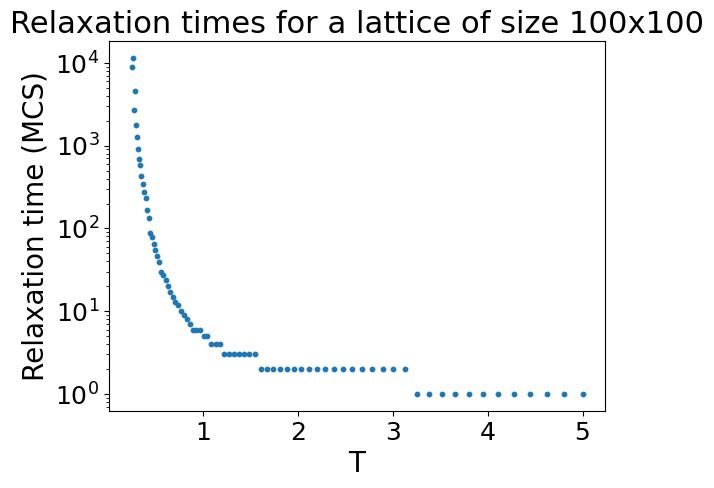

In [5]:
#Plot the relaxation time with the array output of the previous code

tau_100 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 8, 9, 10, 12, 13, 15, 17, 20, 24, 27, 30, 39, 47, 55, 65, 79, 88, 133, 165, 232, 272, 344, 427, 592, 694, 900, 1263, 1787, 4525, 2673, 11494, 8982]
plt.title("Relaxation times for a lattice of size 100x100")
plt.xlabel("T")
plt.ylabel("Relaxation time (MCS)")
plt.scatter(Tn[0:len(tau_100)], tau_100, s=10)
plt.yscale('log')
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.xscale('log')
plt.show()